# Ketterle Group Journal Club Talk, March 13, 2020

## 0. Introduction <a name="introduction"></a>

>"If you take just one piece of information from this blog:
Quantum computers would not solve hard search problems
instantaneously by simply trying all the possible solutions at once." 
>
>Scott Aaronson, *Shtetl-Optimized*

How do quantum algorithms running on quantum computers actually work? A truly quantum algorithm utilizes quantum interference to enhance the probability amplitude for the right answer and reduce that for the wrong answers, as it evolves an input state based on the superposition of all possible states (possible answers). A natural question is then to ask how the algorithm manages to "choreograph" such interference pattern. The goal of this notebook ("virtual talk") is to develop an intuition for design choices behind such "choreography".

The original topic of the talk was going to be about quantum Fourier transform (QFT), and how it is used in Shor's algorithm for factorizing composite integers. It seemed appropriate as Shor's algorithm is an arguably useful quantum algorithm that has exponential speedup compared to classical factoring algorithms. However, it became clear that diving directly into the analysis of Shor's algorithm, especially without previous exposure to quantum algorithms, is quite laborious. So I will focus on an easier, seemingly unrelated problem that, in Shor's own words, inspired him to write his algorithm. 

Here is the structure of the notebook. I will review common qubit operations that can be found in quantum circuits as a nice warm-up. Then I will describe quantum black box models in general and why people were motivated to come up with early quantum algorithms within that theoretical background. Then I will describe Simon's problem within that context and Simon's algorithm that quantumly solves the problem. I will finish by touching briefly on Shor's algorithm.

A lot of the writing below is based on the [online textbook for Qiskit](https://qiskit.org/textbook/preface.html), which is a Python based quantum computation library made by IBM. For more theoretical understanding I consulted Scott Aaronson's [lecture notes](https://www.scottaaronson.com/qclec/combined.pdf), in particular Chapter 17 and beyond.

# Table of contents
1. [Warm-up](#warmup)
    1. [Hadamard gate](#hadamardgate)
    2. [CNOT gate](#CNOTgate)
2. [Quantum black-box model](#quantumblackbox)
    1. [Why deal with black-boxes?](#blackboxtheory)
    2. [Making quantum queries](#quantumquery)
3. [Simon's algorithm](#simon)
    1. [Simon's problem](#simonsproblem)
    2. [The algorithm itself](#simonalgorithm)
4. [Shor's algorithm](#shor)

## 1. Warm-up <a name="warmup"></a>

Let's quickly review some basic operations (gates) that are used in quantum computing. In particular, let's focus on the two most common gates used: the Hadamard gate and the CNOT (or CX) gate. You can probably skip the CNOT gate part without problem but I strongly encourage you to read through the Hadamard gate part.

### 1.1 Hadamard gate <a name="hadamardgate"></a>

The Hadamard gate $H$ is a single qubit gate that transforms from the $\{0,1\}$ basis to $\{|+\rangle,|-\rangle\}$ basis, and vice versa. The two superposition states $\{|+\rangle,|-\rangle\}$ are written in the ordinary $\{0,1\}$ basis as $\{\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right), \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)\}$. In matrix notation,

\begin{align*}
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
\end{align*}

If you take the $H$ operation twice, you get the initial state back: $H^2 = I$. Note that the Hadamard gate is not physically equivalent to a $\pi/2$ Rabi pulse, although both operations put a qubit in 0 or 1 into some superposition state. You can think of the Hadamard gate as a $\pi-$rotation around the $\hat{X}+\hat{Z}$ axis through the Bloch sphere. Alternatively, you can think of it as a $\pi-$rotation around the $\hat{Z}$ axis followed by a $\pi/2-$rotation around the $\hat{Y}$ axis. 

What happens if we have an input of n-qubits $|0\rangle^{\otimes n}$ and we perform $H^{\otimes n}$ on it? We get an uniformly-weighted superposition of all possible n-bit binary strings.

\begin{align*}
H^{\otimes n} |0\rangle^{\otimes n} &= \frac{\left(|0\rangle_1 + |1\rangle_1\right)}{\sqrt{2}}\otimes\cdots \otimes\frac{\left(|0\rangle_n + |1\rangle_n\right)}{\sqrt{2}}\\
&= \frac{1}{\sqrt{2^n}}\sum_{x = \{0,1\}^n} |x\rangle
\end{align*}

The following exercise is trivial in that we already know the answer, but the algebra involved is longer. But the intermediate steps will prove useful later, so don't skip! What if we apply $H^{\otimes n}$ to the above state with superposition of n-bit strings?

\begin{align*}
&H^{\otimes n} \frac{1}{\sqrt{2^n}}\sum_{x = \{0,1\}^n} |x\rangle \\
&= \frac{1}{\sqrt{2^n}}\sum_{x = \{0,1\}^n} H^{\otimes n} |x\rangle\\
&= \frac{1}{\sqrt{2^n}}\sum_{x = \{0,1\}^n} \frac{\left(|0\rangle_1 + (-1)^{x(1)}|1\rangle_1\right)}{\sqrt{2}}\otimes \cdots \otimes \frac{\left(|0\rangle_n + (-1)^{x(n)}|1\rangle_n\right)}{\sqrt{2}}\\
&= \frac{1}{2^n}\sum_{x = \{0,1\}^n}\sum_{y = \{0,1\}^n} (-1)^{x(1)y(1)+\ldots+x(n)y(n)} |y\rangle\\
&= \frac{1}{2^n}\sum_{y = \{0,1\}^n}\sum_{x = \{0,1\}^n} (-1)^{x \cdot y} |y\rangle\\
& \text{(if y is not all zero, the alternating signs from increments in x cancel the summands)}\\
& \text{(if y is all zero, you get the same term $2^n$ times)}\\
&= |0\cdots 0\rangle
\end{align*}

More exercise: if you apply $H^{\otimes n}$ to a qubit encoding n-bit string $a$, what do you get?
Answer: $\frac{1}{\sqrt{2^n}}\sum_{x = \{0,1\}^n} (-1)^{a\cdot x}|x\rangle$. Why?

### 1.2 CNOT (CX) gate <a name="CNOTgate"></a>

The CNOT (or sometimes called CX) gate is the prototypical two-qubit gate and is realized physically by an entangling operation. In many quantum circuit diagrams it is represented as a line connecting the control qubit (small dot) and the target qubit (large plus).

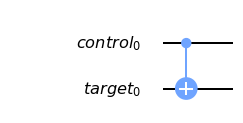

In [1]:
import numpy as np
from qiskit import(
    QuantumRegister,
    QuantumCircuit,
    execute,
    Aer,
    IBMQ)
from qiskit.visualization import plot_histogram, plot_bloch_multivector

qt = QuantumRegister(1,'target')
qc = QuantumRegister(1,'control')
qc = QuantumCircuit(qc,qt)
# initializes two qubits 
qc.cx(0,1)
qc.draw('mpl')

The truth table for this gate explains why it's called Controlled-NOT:

| q_{control} | q_{target} before | q_{target} after |
|-----|------------|-----------|
| 0   | 0          | 0         |
| 0   | 1          | 1         |
| 1   | 0          | 1         |
| 1   | 1          | 0         |

So if we have an input state $|+\rangle_{control}|0\rangle_{target}$, we get output state $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ after CX operation. In general, if qubit $i$ is the control qubit and qubit $j$ is the target qubit, we denote the operation as $CX_{ij}$. 

Now assume we have multiple control and target qubits on a rail, and we apply a bunch of different CX gates. Is there an easy way to quickly determine the output state? Yes. Scan through the list of operations and add 0 or 1 depending on the state of the control qubit. Once that is done for all control and target pairings, take mod 2 for the sums at the end. 

Let's work this example. Assume we have two control qubits 1,2 and two target qubits 3,4. If we have an input state $|\psi\rangle$

\begin{align*}
|\psi\rangle = \left(|0_1 0_2\rangle + |1_1 0_2 \rangle + |1_1 1_2 \rangle\right)|0_3 0_4\rangle
\end{align*}

and apply compound operation $Q = CX_{13} CX_{14} CX_{23} CX_{24}$, what is the output state? The answer is 

\begin{align*}
&|0 0\rangle |0 \oplus 0 \oplus 0, 0 \oplus 0 \oplus 0\rangle + \\
&|1 0 \rangle |0 \oplus 1 \oplus 0, 0 \oplus 1 \oplus 0\rangle + \\
&|1 1 \rangle |0 \oplus 1 \oplus 1, 0 \oplus 1 \oplus 1\rangle \\
& = |00\rangle |00\rangle + |10\rangle |11\rangle + |11\rangle |00\rangle
\end{align*}

Note $\oplus$ is addition mod 2. 

## 2. Quantum black-box model <a name="quantumblackbox"></a>

### 2.1 Why deal with black-boxes? <a id = blackboxtheory ></a>
Let's take a step back and remind ourselves why we are interested in quantum computers. We hear and learn that quantum computers are powerful. But powerful in what sense? It has to easily solve problems that classical computers take a long time solving. What we mean by "easy" is that the number of elementary steps taken to produce the desired answer is relatively small. In the case of classical computers, that elementary step can be a floating point operation, for example. What about quantum computers? Maybe that could be the number of rudimentary gates used to construct the unitary transformation that transforms your input state to the desired output state. So if we were to have a quantum algorithm and prove its supremacy, we would have to look at what kind of unitary transformation it is trying to implement, come up with a lower bound on the number of gates to realize that unitary, and show that it is small. 

So far everything I said here seems natural, but the catch is that determination of the circuit complexity of a unitary is insanely hard, according to experts. Even worse, that hardness has nothing to do with quantum mechanics. There are possibly some situations where even the upper bound is guaranteed to be relatively small, but outside of that circuit complexity is not best suited to show the strengths of quantum computers. This motivates us to consider a more limited model of complexity, and that is query complexity. 

The query complexity of an algorithm is measured by the number of queries made to a black-box function (also known as *oracle* in computer science). The only thing you know about the given black-box function is that it exists (don't worry about whether it *can* exist), and gives you an output bitstring $f(x)$ if you give it an input bitstring $x$, where $f:\{0,1\}^n \to \{0,1\}^m$. The task at hand is then trying to learn some property of this black-box only by making queries instead of looking at its internals. And the fewer the number of queries, the better the algorithm is. Note that this means, we count any gates that come before or after queries as cost-free. Is it possible that by querying on a superposition of inputs, and getting back a superposition of answers, I learn more about the black-box function than making a random queue of queries? We will see. 

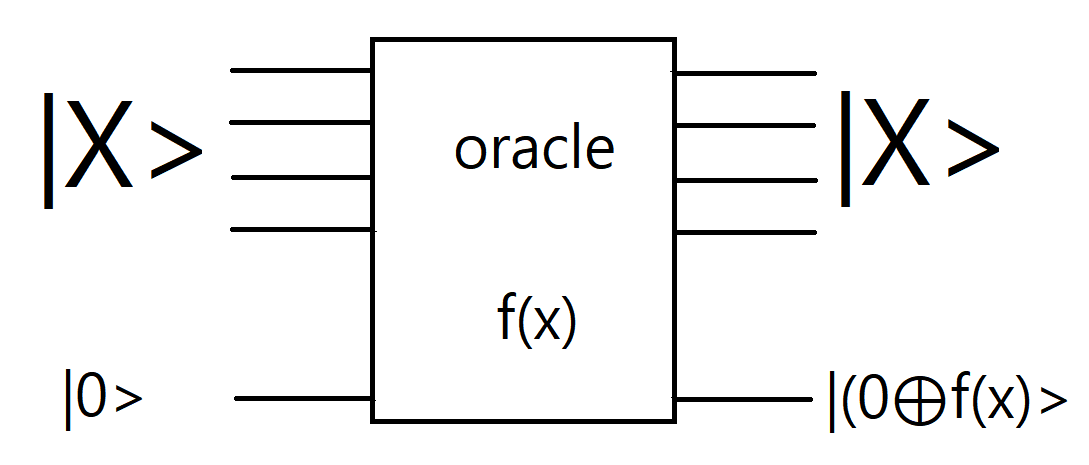

In [8]:
from IPython.display import Image
Image("Desktop/oracle.png",width = 400, metadata = {'date':'hi'})

### 2.2 Making quantum queries <a id = quantumquery></a>
Hopefully I have convinced you that studying queries to black-box functions is worth our time. Now let's learn how to make a query quantum mechanically.

We will start with two qubit registers: the first one for the input string, and the second for storing the result of the query. After the query, our input state $|x,y\rangle$ will transform into $|x,y \oplus f(x)\rangle$. If $y$ is all zeros, then we have written the query result into the second register. And of course, if $y$ is all ones, then we get the binary complement of $f(x)$. This mode of storing query into the state of the qubit register is known as XOR query.

There is another method of making a query, and that is phase query: you encode the query result into the phase of the amplitude rather than into the state: $(-1)^{f(x)}|x\rangle$. You can also this variant where we append a control qubit $|b\rangle$ and if you pass $|x,b\rangle$ as an input, you get out $(-1)^{f(x)\cdot b}|x,b\rangle$.

Let me say again that we don't care what kind of gates are inside the black-box function. We just assume that it can do what we want, as a phase query or an XOR query. And it turns out that you can turn an XOR query into  a phase query and vice versa, at no cost. Hint: Start from $\frac{1}{\sqrt{2}}\left(|x,0\rangle - |x,1\rangle\right)$ as an input to an XOR query.

To end this section, let's review **Deutsch's algorithm**, which is one of the earliest quantum algorithm from the mid 1980's. It gives a simple flavor of the quantum black-box problem.

> Suppose we are given two unknown bits $b_0$ and $b_i$.
> Given an index $x \in \{0,1\}$, our black box function $f$ returns $f(x) = b_{x}$.
> What is the parity of the two bits (e.g. = 1 if they are different)?

Classically, you will have to query twice to know both bits and then calculate the parity. Quantumly, it can be done with single query as follows. 

\begin{align*}
|0\rangle \underset{\text{Hadamard}}{\to} \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right) \underset{\text{phase query}}{\to} \frac{1}{\sqrt{2}}\left((-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\right) 
\end{align*}

If $f(0)=f(1)$, then we get $|+\rangle$ up a phase. If not, we get $|-\rangle$ up to a phase. Applying a final Hadamard, we get $|0\rangle$ or $|1\rangle$, and this is indeed the parity of the two-bit set. So in general, for a n-bit input, Deutsch's algorithm reduces classical query complexity by half. It's not impressive, I know, but it's simple enough to understand. And things start to get interesting from here.

Ideally, you will also read about **Deutsche-Jozsa algorithm** and **Bernstein-Vazirani algorithm** but let me skip ahead to **Simon's algorithm** to save your reading time boxes). Deutsche-Josza algorithm is basically a n-qubit extension to the simple Deutsche algorithm above: just replace the Hadamards $H$ at the front and at the back with $H^{\otimes n}$ respectively. Bernstein-Vazirani algorithm has essentially the same structure, but for a different problem.

If you are bored at this point and ready to quit, just remember that solving black-box model generally has the structure of Hadamarding the input, sending into a query, and Hadamarding again the query result, regardless of the problems described! Keeping this mental picture will make the reading of the references smoother. Understanding the example and the exercise given in [Section 1.1](#hadamardgate) will help a lot.

## 3. Simon's algorithm <a name="simon"></a>

### 3.1 Simon's problem <a id=simonsproblem></a>
I said at the intro that Simon's algorithm is a quantum algorithm that solves Simon's problem. So what is that problem? First the backstory. Simon was convinced that there is a limit to achieving a "true" exponential quantum speedup with quantum algorithms. He ended up proving that there is such one for an artificial problem (and as Shor found out, similarly for the not-so-artificial problem of factoring integers). What we mean by "true" speedup is that we allow classical computers to try non-deterministic, probabilistic answers to improve their speed, and compare our quantum speedup to that.

Finally, here is the long-awaited Simon's problem.
> Given black-box $f:\{0,1\}^n \to \{0,1\}^n$
> we are promised that there is a secret non-trivial bitstring $s \neq 0^n$, such that $f(x) = f(y)$ if and only if $y = x \oplus s$ for all inputs $x,y$. Find the secret bitstring $s$. 
>
>NOTE: $\oplus$ is XOR or equivalently addition mod 2.

In other words, if an input string has some output, the complement to the input string also has the same output. Otherwise, all distinct inputs not related as complements give distinct outputs. Thus, $f$ is a two-to-one function. An example would be $f(n) = 2\cdot \mathrm{floor}[n/2] + 1$, giving outputs 1,1,3,3,5,5, for inputs 0,1,2,3,4,5. Translated into binaries, this would be (restricting to 3 bits) output list of 001,001,011,011,101,101 for input list of 000,001,010,011,100,101. We see that the secret bitstring $s$ is 001. 

The example above was easy to solve in the sense that the two equivalent outputs were nearest neighbors, so we only needed the first two queries to make a guess at $s$. But what if equivalent outputs are scattered around in random fashion, and we have a n-bit long input string? In the worse case, you will have to query $2^{n-1} + 1$ to detect two equivalent outputs and answer the problem without error.

In principle, the probability of having only dissimilar outputs decreases as the number of query increases. You may be familiar with the [birthday problem](https://en.wikipedia.org/wiki/Birthday_problem) - to reach 50% chance of at least two people in a room, sharing a birthday, you only need 23 people. Note $\sqrt{365} \approx 19$. If there were $n$ days in a year, you would need in general $\approx \sqrt{n}$ people in a room to have a decent chance of sharing a birthday. This is due to the quadratic scaling of numbers of pairs as number of people in the room grows (i.e. collision chance grows fast). By this logic, classically, if you allow some error, you can determine $s$ within $O(2^{n/2})$ with high probability. Let's accept for now that you cannot do better than this scaling for classical computers.

Now that we understand this artificial but interesting problem and the classical bound for query complexity, we jump to Simon's algorithm, which can solve the problem in $O(n)$ queries!

### 3.2 The algorithm itself <a id=simonalgorithm></a>

Without thinking hard, we prepare two $H^{\otimes n}$ gates, one before the query and one after the query, because what else can we do? On the rails of the circuit, there will be a register of $n$ qubits for the input, and a register of $n$ qubits for the memory. This time, we ask that the query be a XOR query. We start with all the qubits in both registers as zeros.

All right, here is the sequence. Send in two registers of zeros, with the first register going through $H^{\otimes n}$. Then query the black-box. After the query, measure the second register (the memory register). We don't care what value of $f(x)$ we measure so there is no need to record that measurement. After that, apply $H^{\otimes n}$ to the first register (the input) again and measure it. 

After the first n-qubit Hadamard and the query, the total state looks like this:
\begin{align*}
\frac{1}{\sqrt{2^n}}\sum_{x=\{0,1\}^n}|x\rangle_{input}|f(x)\rangle_{memory}
\end{align*}

Once we measure the memory register, we project the total state to $\frac{1}{\sqrt{2}}\left(|x \rangle + |y\rangle\right)$ where $f(y) = f(x) = \text{what you measured}$. Remember that $f$ is a two-to-one function. By the definition of $f$, we are guaranteed that $y = x \oplus s$. 

After the last Hadamard, the input state has transformed into (now we drop the memory ket) 

\begin{align*}
\frac{1}{\sqrt{2^{n+1}}}\sum_{z = \{0,1\}^n}\left((-1)^{x \cdot z} + (-1)^{y \cdot z}\right)|z\rangle
\end{align*}

If you don't follow go back to the last part of [Section 1.1](#hadamardgate).

Now what happens after the final step of the algorithm: measurement on the input state? Let's assume we measure a bitstring $z$. The fact that we got that measurement means the probability amplitude for it is non-zero (duh). That implies $(-1)^{x \cdot z}$ and $(-1)^{y \cdot z}$ cannot cancel each other, i.e., they must be equal.

\begin{align*}
x \cdot z &= y \cdot z\\
&= (x \oplus s) \cdot z\\
0 &= s \cdot z
\end{align*}

Great, we learned something about $s$ directly from that measurement. Now repeat that measurement $O(n)$ times, until we measure n distinct values of $z$ (out of $2^n$ mind you), and then we can reconstruct the hidden bitstring $s$ by classically solving linear system of equations. Voila!

Since the stated goal of the notebook was to gain intuition behind designing the right interference pattern for quantum algorithms, where was the magic of interference in this situation? I think it is most apparent in the final step, where constructive interference gives you $x\cdot z = y\cdot z$ and destructive interference drops out the other case.

To simulate a Simon's circuit, visit https://qiskit.org/textbook/ch-algorithms/simon.html. You can copy the code from the textbook and run it here. Or better yet, make an account at IBM Q Experience and run your demo circuit for real on a 5-qubit device, for free. The website has an online Jupyter server. You should definitely give it a try! 

## 4. Shor's algorithm

Congratulations on making this far ;)!

Peter Shor showed that you can reduce the factoring problem into a period-detection problem, which can be done efficiently by a quantum algorithm. The function whose period we are interested in is $f(x) = a^x\,\text{mod}\,N$, where integer $a < N$ and $N$ (which we want to factorize) are coprime. 

To understand the number theory argument to get to this reduction stage, I'll just write down the chain of logic.
1. Understand Euclidean algorithm to obtain the greatest common divisor of two numbers.
2. Understand that 1. implies Bezout's identity (most important): if $a$ and $b$ are coprime, there exist integer $p$ and $q$ such that $p\cdot a + q \cdot r = 1$ 
3. Understand that 2. implies residue classes of modulo n that are coprime to n form a group under multiplication (specifically, 2. helps you find the inverse).
4. Understand that 3. implies Euler's theorem. 
5. Understand that 4. implies the sizes of the subgroups of the abovementioned group are related to the periods we want to find.

Of course, you really don't need to know this to appreciate the algorithm itself. It's just that there is some pre-processing and post-processing around the quantum part of the algorithm, and that requires some knowledge of number theorey.

To make some connection to Simon's algorithm, let's borrow the language we used in Section 3. The periodic function $f$ is like our black-box function that we will query. Specifically: $f:\mathbb{N} \to \mathbb{N}$ and you are guaranteed that there is a secret number $s$ (the period) such that $f(x) = f(y)$ if and only iff $s$ (divides y-x) for all x,y (x<y). The key insight here is that we don't need to query the function too many times. In principle, if the algorithm can pick out $y-x$ after each query, after a few queries, we can take the greatest common divisor of the $(y-x)$ we have measured and that would already be a very good guess. But I don't want to suggest that is the actual picture.

Now go to https://en.wikipedia.org/wiki/Shor%27s_algorithm#/media/File:Shor's_algorithm.svg. You see the familiar structure of two quantum registers (the top being the input and the bottom being the memory). The input register is Hadamarded as usual. The dizzing array of operations after that is the actual implementation of the periodic function $f$: the modular exponentiation is realized as *repeated squaring* of the base ($a$ in the diagram). Example: $3^9\,\text{mod}\,7$ is realized as $((3^2)^2)^2 * 3\,\text{mod}\,7$.

Okay, so we can summarize the circuit up that point as 1) Hadamard the input and 2) query our "black-box" function. What follows after is not a simple Hadamard but inverse quantum Fourier transform. Quantum fourier transform works similarly as discrete fourier transform that runs on your MATLAB, but it has a bunch of kets stuck in it in the description ;).

Note that in the diagram, the output register lines are left dangling. That is because we don't care about the actual values of $f(x)$ measured. **Just like in Simon's algorithm, we only care that the simple act of querying resulted in an entangled state described as sums of $|x,f(x)\rangle$**. To describe how the rest of the quantum circuit works, I would have to describe how the inverse quantum Fourier transform picks out the hidden period $s$, but I'll stop here. 

P.S: Typically Shor's algorithm is covered over multiple lectures in a quantum information class, so if you feel like you learned something after reading Section 3 and then Section 4, I say I have done a good job :)!